In [1]:
!pip install mne
import mne
import warnings
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt
from time import time
from sklearn.svm import SVC
from scipy.io import loadmat
from scipy.stats import norm
from scipy.linalg import eigh
from scipy.fftpack import fft
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.signal import lfilter, butter, filtfilt, firwin, iirfilter, decimate, welch

warnings.filterwarnings("ignore", category=DeprecationWarning)
mne.set_log_level(50, 50)

def extractEpochs(data, events, smin, smax, class_ids):
    events_list = events[:, 1] # get class labels column
    cond = False
    for i in range(len(class_ids)): cond += (events_list == class_ids[i]) #get only class_ids pos in events_list
    idx = np.where(cond)[0]
    s0 = events[idx, 0] # get initial timestamps of each class epochs
    sBegin = s0 + smin
    sEnd = s0 + smax
    n_epochs = len(sBegin)
    n_channels = data.shape[0]
    n_samples = smax - smin
    epochs = np.zeros([n_epochs, n_channels, n_samples])
    labels = events_list[idx]
    bad_epoch_list = []
    for i in range(n_epochs):
        epoch = data[:, sBegin[i]:sEnd[i]]
        if epoch.shape[1] == n_samples: epochs[i, :, :] = epoch # Check if epoch is complete
        else:
            print('Incomplete epoch detected...', n_samples, '!=', epoch.shape[1])
            bad_epoch_list.append(i)
    labels = np.delete(labels, bad_epoch_list)
    epochs = np.delete(epochs, bad_epoch_list, axis=0)
    return epochs, labels
    
def nanCleaner(epoch):
    """Removes NaN from data by interpolation
    data_in : input data - np matrix channels x samples
    data_out : clean dataset with no NaN samples"""
    for i in range(epoch.shape[0]):
        bad_idx = np.isnan(epoch[i, :])
        epoch[i, bad_idx] = np.interp(bad_idx.nonzero()[0], (~bad_idx).nonzero()[0], epoch[i, ~bad_idx])
    return epoch
    
def corrigeNaN(data):
    for ch in range(data.shape[0] - 1):
        this_chan = data[ch]
        data[ch] = np.where(this_chan == np.min(this_chan), np.nan, this_chan)
        mask = np.isnan(data[ch])
        meanChannel = np.nanmean(data[ch])
        data[ch, mask] = meanChannel
    return data


class Filter:
    def __init__(self, fl, fh, Fs, filtering, band_type='bandpass'):
        self.ftype = filtering['design']
        if self.ftype != 'DFT':
            nyq = 0.5*Fs
            low = fl/nyq
            high = fh/nyq        
            if low == 0: low = 0.001
            if high >= 1: high = 0.999
            if self.ftype == 'IIR':
                # self.b, self.a = iirfilter(filtering['iir_order'], [low, high], btype='band')
                self.b, self.a = butter(filtering['iir_order'], [low, high], btype=band_type)
            elif self.ftype == 'FIR':
                self.b, self.a = firwin(filtering['fir_order'], [low, high], window='hamming', pass_zero=False), [1]

    def apply_filter(self, X, is_epoch=False):
        if self.ftype != 'DFT': XF = lfilter(self.b, self.a, X) # lfilter, filtfilt
        else:
            XF = fft(X)
            if is_epoch:
                real, imag = np.real(XF).T, np.imag(XF).T
                XF = np.transpose(list(itertools.chain.from_iterable(zip(imag, real))))
            else:
                real = np.transpose(np.real(XF), (2, 0, 1))
                imag = np.transpose(np.imag(XF), (2, 0, 1))
                XF = np.transpose(list(itertools.chain.from_iterable(zip(imag, real))), (1, 2, 0)) 
        return XF

class CSP:
    def __init__(self, n_components):
        self.n_components = n_components
        self.filters_ = None
    def fit(self, X, t):
        ch = X.shape[1]
        class_ids = np.unique(t)   
        X1 = X[class_ids[0] == t]
        X2 = X[class_ids[1] == t]
        S1, S2 = np.zeros((ch, ch)), np.zeros((ch, ch))  
        for i in range(len(X1)): S1 += np.dot(X1[i], X1[i].T) / X1[i].shape[-1] # cov X[i]
        for i in range(len(X2)): S2 += np.dot(X2[i], X2[i].T) / X2[i].shape[-1] # ...sum((X*X.T)/q)
        S1 /= len(X1); 
        S2 /= len(X2)
        [D, W] = eigh(S1, S1 + S2) # + 1e-10 * np.eye(22))
        ind = np.empty(ch, dtype=int)
        ind[0::2] = np.arange(ch-1, ch//2 - 1, -1) 
        ind[1::2] = np.arange(0, ch//2)
        # W += 1e-1 * np.eye(22)
        W = W[:, ind]
        self.filters_ = W.T[:self.n_components]
        return self # used on cross-validation pipeline
    def transform(self, X):        
        Y = np.asarray([np.dot(self.filters_, ep) for ep in X])
        # FEAT = np.log(np.mean(Y**2, axis=2))
        FEAT = np.log(np.var(Y, axis=2))
        return FEAT

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 7.4 MB 21.9 MB/s 
Mounted at /content/drive


In [4]:
# ==============================================================
# SETUP
# ==============================================================
suj = 1
class_ids = [1,2]
# tmin, tmax, fl, fh, ncsp, nbands = 0.5, 2.5, 8, 30, 8, 9
tmin, tmax, fl, fh, ncsp, nbands = -2, 0, 8, 30, 8, 9
Fs = 250
smin, smax = int(tmin*Fs), int(tmax*Fs)
filtering = {'design':'DFT'} 
# filtering = {'design':'IIR', 'iir_order':5}

In [5]:
# ==============================================================
# LOADING DATASETS
# ==============================================================

# TRAINING DATASET
eeg = mne.io.read_raw_gdf('/content/drive/My Drive/BCI_workgroup/dataset/IV2a/A0' + str(suj) + 'T.gdf').load_data()
data1 = eeg.get_data()[:22] # [channels x samples]
events1 = mne.events_from_annotations(eeg) # raw.find_edf_events()
events1 = np.delete(events1[0], 1, axis=1)
                    
ZT, tt = extractEpochs(data1, events1, smin, smax, [7,8,9,10] )
for i,k in zip([7,8,9,10], range(1, 5)): tt = np.where(tt == i, k, tt)
ZT = np.vstack([ ZT[np.where(tt == k)] for k in class_ids ])
tt = np.hstack([ np.ones(len(ZT)//2)*k for k in class_ids ]).astype(int)


# TEST DATASET
eeg = mne.io.read_raw_gdf('/content/drive/My Drive/BCI_workgroup/dataset/IV2a/A0' + str(suj) + 'E.gdf').load_data()
data2 = eeg.get_data()[:22] # [channels x samples]
events2 = mne.events_from_annotations(eeg) # raw.find_edf_events()
events2 = np.delete(events2[0], 1, axis=1)

ZV, _ = extractEpochs(data2, events2, smin, smax, [7])
tv = np.ravel(loadmat('/content/drive/My Drive/BCI_workgroup/dataset/IV2a/true_labels/A0' + str(suj) + 'E.mat')['classlabel'])
ZV = np.vstack([ ZV[np.where(tv == k)] for k in class_ids ])
tv = np.hstack([ np.ones(len(ZV)//2)*k for k in class_ids ]).astype(int)

In [6]:
# ==============================================================
# TRAINING BCI
# ==============================================================
step = (fh-fl) / (nbands+1) # n_bins/nbands+1
size = step / 0.5 # step/overlap
sub_bands = []
for i in range(nbands):
  fl_sb = i * step + fl
  fh_sb = i * step + size + fl
  sub_bands.append([fl_sb, fh_sb])

if filtering['design'] == 'DFT':
  bsize = 2/(Fs/ZT.shape[-1]) # 2 == sen/cos
  filt = Filter(fl, fh, Fs, filtering)
  XTF = filt.apply_filter(ZT)  
  XT = [ XTF[:, :, round(sub_bands[i][0]*bsize):round(sub_bands[i][1]*bsize)] for i in range(nbands) ]
elif filtering['design'] == 'IIR':
  filt = Filter(sub_bands[i][0], sub_bands[i][1], Fs, filtering)
  XT = [ filt.apply_filter(ZT) for i in range(nbands) ]

csp = [ CSP(n_components=ncsp) for i in range(nbands) ] # mne.decoding.CSP()
for i in range(nbands): csp[i].fit(XT[i], tt)
FT = [ csp[i].transform(XT[i]) for i in range(nbands) ]

ldas = [ LDA() for i in range(nbands) ]
for i in range(nbands): ldas[i].fit(FT[i], tt)
ST = np.asarray([ np.ravel(ldas[i].transform(FT[i])) for i in range(nbands)]).T # Score LDA

p0 = norm(np.mean(ST[tt == class_ids[0], :], axis=0), np.std(ST[tt == class_ids[0], :], axis=0))
p1 = norm(np.mean(ST[tt == class_ids[1], :], axis=0), np.std(ST[tt == class_ids[1], :], axis=0))
META_ST = np.log(p0.pdf(ST) / p1.pdf(ST))

svm = SVC(kernel='linear', C=1e-4, probability=True)
svm.fit(META_ST, tt)

SVC(C=0.0001, kernel='linear', probability=True)

In [7]:
# ==============================================================
# TEST BCI (All evaluate trials)
# ==============================================================

if filtering['design'] == 'DFT':
  bsize = 2/(Fs/ZV.shape[-1]) # 2 == sen/cos
  filt = Filter(fl, fh, Fs, filtering)
  XVF = filt.apply_filter(ZV)  
  XV = [ XVF[:, :, round(sub_bands[i][0]*bsize):round(sub_bands[i][1]*bsize)] for i in range(nbands) ]
elif filtering['design'] == 'IIR':
  filt = Filter(sub_bands[i][0], sub_bands[i][1], Fs, filtering)
  XV = [ filt.apply_filter(ZV) for i in range(nbands) ] 

FV = [ csp[i].transform(XV[i]) for i in range(nbands) ]
SV = np.asarray([ np.ravel(ldas[i].transform(FV[i])) for i in range(nbands)]).T 
META_SV = np.log(p0.pdf(SV) / p1.pdf(SV))

y, yp = svm.predict(META_SV), svm.predict_proba(META_SV)
acc_svm = round(np.mean(y == tv)*100,2) # round(svm.score(META_SV, tv)*100,2)
print('SVM acc:', acc_svm)

SVM acc: 50.0


In [8]:
# ==============================================================
# TEST (single trial)
# ==============================================================
epoch = random.randint(0, 144) # índice aleatório da época (O robô deve entregar esse índice - você pode dividir em duas sacolas)
if filtering['design'] == 'DFT':
  bsize = 2/(Fs/ZV.shape[-1]) # 2 == sen/cos
  filt = Filter(fl, fh, Fs, filtering)
  XVF = filt.apply_filter(ZV[epoch], is_epoch=True)
  XV = [ XVF[:, round(sub_bands[i][0]*bsize):round(sub_bands[i][1]*bsize)] for i in range(nbands) ]
elif filtering['design'] == 'IIR':
  filt = Filter(sub_bands[i][0], sub_bands[i][1], Fs, filtering)
  XV = [ filt.apply_filter(ZV[epoch], is_epoch=True) for i in range(nbands) ]

FV = [ np.log(np.var(np.dot(csp[i].filters_, XV[i]), axis=1)) for i in range(nbands) ] # mesmas rotinas do csp.transform (nada mais que log da variância da época filtrada)
SV = np.asarray([ np.ravel(ldas[i].transform(FV[i].reshape(1, -1))) for i in range(nbands)]).T # Os classificadores sklearn exigem uma entrada 2D, por isso o reshape
META_SV = np.log(p0.pdf(SV) / p1.pdf(SV))
y, yp = svm.predict(META_SV.reshape(1, -1)), svm.predict_proba(META_SV.reshape(1, -1))
print("Saída época {}: {} {}".format(epoch, y, 'esquerda' if y==1 else 'direita'))

Saída época 9: [1] esquerda


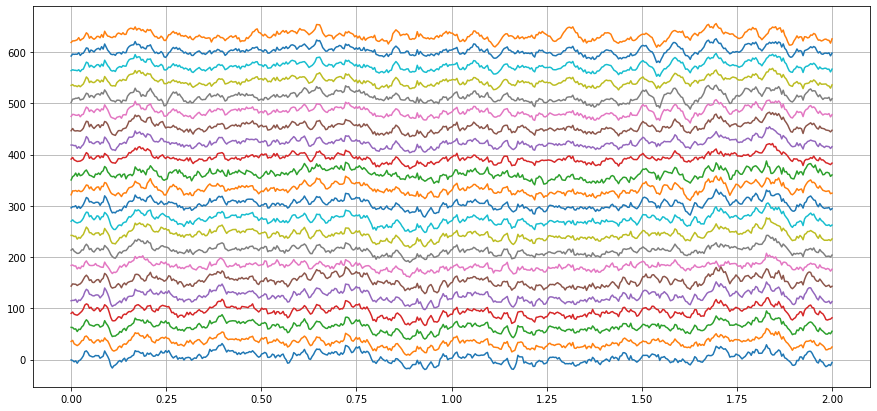

In [10]:
## Teste Cleison
trial = 6
t = np.linspace(0,2,500)
plt.figure(figsize=(15,7))
for channel in range(0,22):
  plt.plot(t, channel*30 + 1e6*ZT[trial,channel,:]) # ZT [trial, channel, samples]
plt.grid()
plt.show()

print()